In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,roc_auc_score,classification_report,confusion_matrix,roc_curve
from sklearn.model_selection import RandomizedSearchCV
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings("ignore")

In [2]:
data=pd.read_excel("customer_churn_large_dataset.xlsx")

In [3]:
data

,CustomerID,Name,Age,Gender,Location,Subscription_Length_Months,Monthly_Bill,Total_Usage_GB,Churn
0,1,Customer_1,63,Male,Los Angeles,17,73.36,236,0
1,2,Customer_2,62,Female,New York,1,48.76,172,0
2,3,Customer_3,24,Female,Los Angeles,5,85.47,460,0
3,4,Customer_4,36,Female,Miami,3,97.94,297,1
4,5,Customer_5,46,Female,Miami,19,58.14,266,0
...,...,...,...,...,...,...,...,...,...
99995,99996,Customer_99996,33,Male,Houston,23,55.13,226,1
99996,99997,Customer_99997,62,Female,New York,19,61.65,351,0
99997,99998,Customer_99998,64,Male,Chicago,17,96.11,251,1
99998,99999,Customer_99999,51,Female,New York,20,49.25,434,1


## Data Preprocessing

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   CustomerID                  100000 non-null  int64  
 1   Name                        100000 non-null  object 
 2   Age                         100000 non-null  int64  
 3   Gender                      100000 non-null  object 
 4   Location                    100000 non-null  object 
 5   Subscription_Length_Months  100000 non-null  int64  
 6   Monthly_Bill                100000 non-null  float64
 7   Total_Usage_GB              100000 non-null  int64  
 8   Churn                       100000 non-null  int64  
dtypes: float64(1), int64(5), object(3)
memory usage: 6.9+ MB


In [5]:
data.shape

(100000, 9)

In [6]:
data.isnull().sum() # their are no null values

CustomerID                    0
Name                          0
Age                           0
Gender                        0
Location                      0
Subscription_Length_Months    0
Monthly_Bill                  0
Total_Usage_GB                0
Churn                         0
dtype: int64

#### As in the data  the 'CustomerID' and 'Name' column is same as that of the index so we try to drop those two columns

In [7]:
data=data.drop(['CustomerID','Name'],axis=1)

In [8]:
data

,Age,Gender,Location,Subscription_Length_Months,Monthly_Bill,Total_Usage_GB,Churn
0,63,Male,Los Angeles,17,73.36,236,0
1,62,Female,New York,1,48.76,172,0
2,24,Female,Los Angeles,5,85.47,460,0
3,36,Female,Miami,3,97.94,297,1
4,46,Female,Miami,19,58.14,266,0
...,...,...,...,...,...,...,...
99995,33,Male,Houston,23,55.13,226,1
99996,62,Female,New York,19,61.65,351,0
99997,64,Male,Chicago,17,96.11,251,1
99998,51,Female,New York,20,49.25,434,1


##### as here we found their no chance of data imbalance since their is not much difference between the data
#### 0 indicate they are not losing any subscriber means not churn
#### 1 inicate they lost that subscriber means churn

In [9]:
data.Churn.value_counts() 

0    50221
1    49779
Name: Churn, dtype: int64

<AxesSubplot:xlabel='Churn', ylabel='count'>

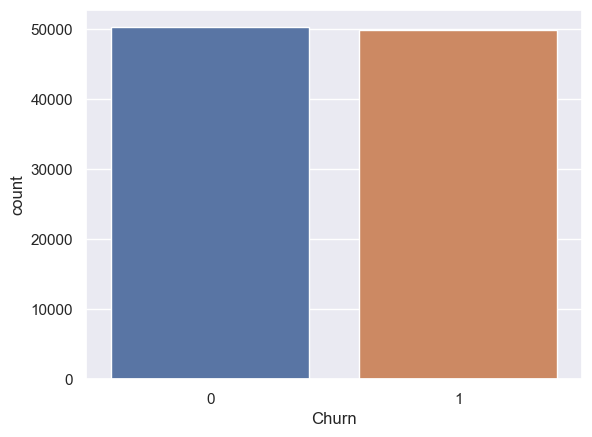

In [10]:
sns.set_theme()
sns.countplot(data.Churn)

In [11]:
def percent(ax,feature):
    total=len(feature)
    for p in ax.patches:
        percentage='{:.1f}%'.format(100*p.get_height()/total)
        x=p.get_x()+p.get_width()/2-0.05
        y=p.get_y()+p.get_height()
        ax.annotate(percentage,(x,y),size=10)

In [12]:
counts=data['Churn'].value_counts()
percs=data['Churn'].value_counts(normalize=True).mul(100).round(1).astype(str)+'%'
pd.concat([counts,percs],axis=1,keys=['count','percentage'])

,count,percentage
0,50221,50.2%
1,49779,49.8%


In [13]:
data.Gender.value_counts()

Female    50216
Male      49784
Name: Gender, dtype: int64

<AxesSubplot:xlabel='Gender', ylabel='count'>

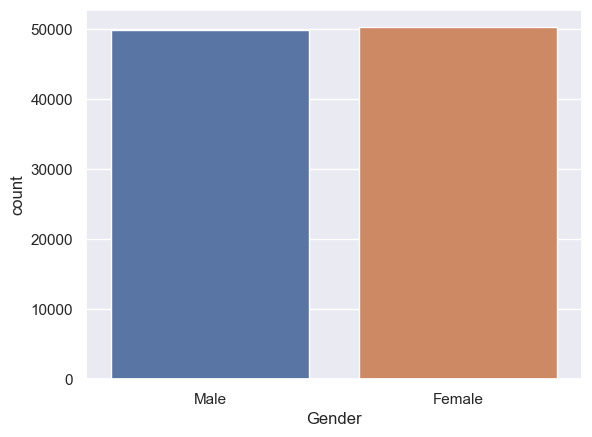

In [14]:
sns.set_theme()
sns.countplot(data.Gender)

In [15]:
counts=data['Gender'].value_counts()
percs=data['Gender'].value_counts(normalize=True).mul(100).round(1).astype(str)+'%'
pd.concat([counts,percs],axis=1,keys=['count','percentage'])

,count,percentage
Female,50216,50.2%
Male,49784,49.8%


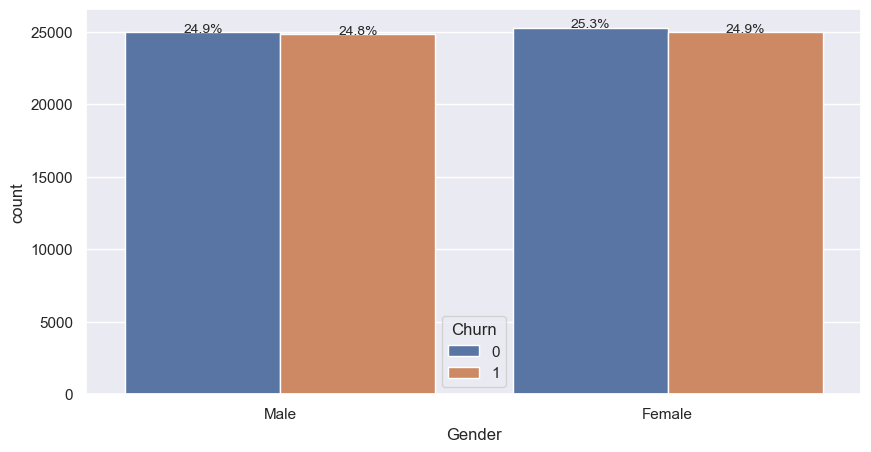

In [16]:
plt.figure(figsize=(10,5))
ax_gender=sns.countplot(data.Gender,hue=data.Churn,data=data)
percent(ax_gender,data['Churn'])

#### here we finding that they are equal rating subscriber and also the one who left the subsciption
#### that is thier is equal rate of churn and not churn customers

In [17]:
data.columns

Index(['Age', 'Gender', 'Location', 'Subscription_Length_Months',
       'Monthly_Bill', 'Total_Usage_GB', 'Churn'],
      dtype='object')

In [18]:
data.Location.value_counts()

Houston        20157
Los Angeles    20041
Miami          20031
Chicago        19958
New York       19813
Name: Location, dtype: int64

<AxesSubplot:xlabel='Location', ylabel='count'>

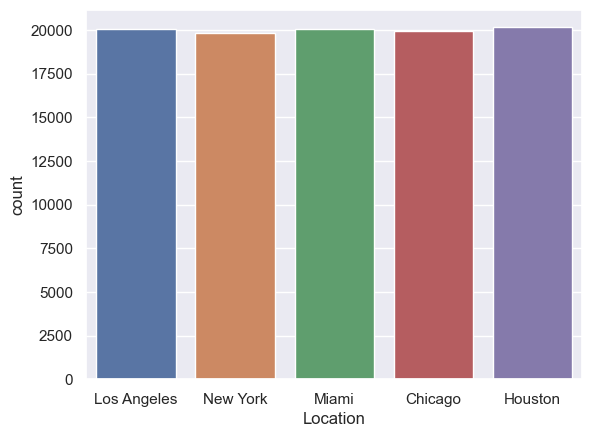

In [19]:
sns.countplot(data.Location)

In [20]:
counts=data['Location'].value_counts()
percs=data['Location'].value_counts(normalize=True).mul(100).round(1).astype(str)+'%'
pd.concat([counts,percs],axis=1,keys=['count','percentage'])

,count,percentage
Houston,20157,20.2%
Los Angeles,20041,20.0%
Miami,20031,20.0%
Chicago,19958,20.0%
New York,19813,19.8%


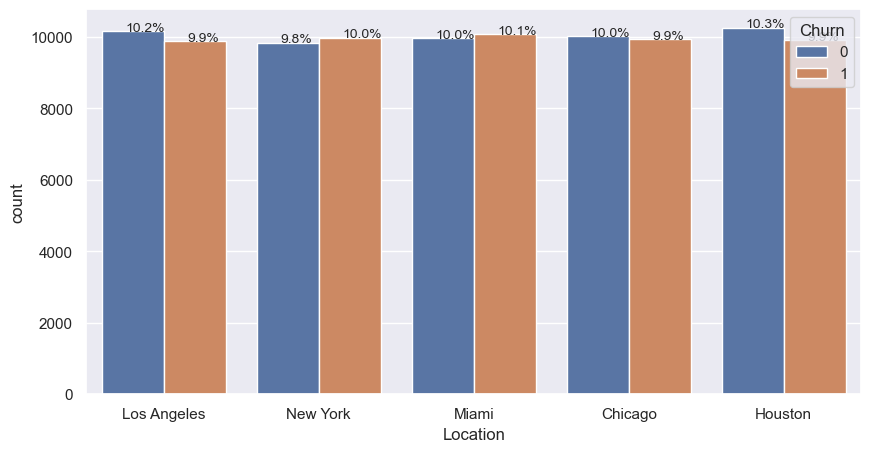

In [21]:
plt.figure(figsize=(10,5))
ax_location=sns.countplot(data.Location,hue=data.Churn,data=data)
percent(ax_location,data['Churn'])

#### As here also in each location the churn rate is equal that is not churn anc churn are almost same in all location
#### that is thier is equal rate of churn and not churn customers in all the location they mentioned

In [22]:
data.columns

Index(['Age', 'Gender', 'Location', 'Subscription_Length_Months',
       'Monthly_Bill', 'Total_Usage_GB', 'Churn'],
      dtype='object')

In [23]:
data.Subscription_Length_Months.unique()

array([17,  1,  5,  3, 19, 15, 10, 12, 20, 13,  8, 23,  2,  4, 18,  9, 14,
       16,  6,  7, 24, 22, 11, 21], dtype=int64)

In [24]:
sub=data.groupby(['Subscription_Length_Months']).size().reset_index().rename(columns={0:'Number of customers'})

In [25]:
sub

,Subscription_Length_Months,Number of customers
0,1,4247
1,2,4228
2,3,4136
3,4,4098
4,5,4171
5,6,4184
6,7,4211
7,8,4106
8,9,4134
9,10,4151


<AxesSubplot:xlabel='Subscription_Length_Months', ylabel='Number of customers'>

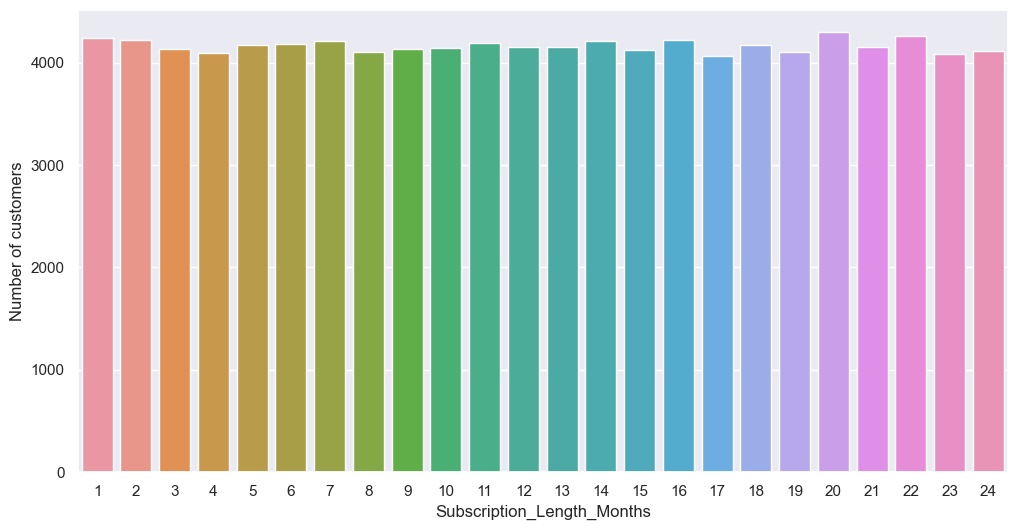

In [26]:
import matplotlib
matplotlib.rcParams['figure.figsize']=(12,6)
sns.barplot(x='Subscription_Length_Months',y='Number of customers',data=sub)

#### for each subscription length their are atleast 4000 customers among 20 month subscription are with most

In [27]:
data.columns

Index(['Age', 'Gender', 'Location', 'Subscription_Length_Months',
       'Monthly_Bill', 'Total_Usage_GB', 'Churn'],
      dtype='object')

In [28]:
gb_use=data.groupby(['Total_Usage_GB']).size().reset_index().rename(columns={0:'Customers'})

In [29]:
gb_use

,Total_Usage_GB,Customers
0,50,253
1,51,211
2,52,247
3,53,216
4,54,206
...,...,...
446,496,223
447,497,220
448,498,207
449,499,236


In [30]:
gb_use.describe()

,Total_Usage_GB,Customers
count,451.000000,451.000000
mean,275.000000,221.729490
std,130.336743,15.252759
min,50.000000,172.000000
25%,162.500000,211.000000
50%,275.000000,221.000000
75%,387.500000,232.000000
max,500.000000,270.000000


In [31]:
gb_use.min()

Total_Usage_GB     50
Customers         172
dtype: int64

In [32]:
gb_use.max()

Total_Usage_GB    500
Customers         270
dtype: int64

#### as from the data the minimun GB used is 50 and maximum GB is 500 GB
#### and their are 172 customers are the minimum customers who are using less GB
#### and their are 270 customers who are using the maximum GB

In [33]:
data.columns

Index(['Age', 'Gender', 'Location', 'Subscription_Length_Months',
       'Monthly_Bill', 'Total_Usage_GB', 'Churn'],
      dtype='object')

In [34]:
monthly=data.groupby(['Monthly_Bill']).size().reset_index().rename(columns={0:'Customers'})

In [35]:
monthly.describe()

,Monthly_Bill,Customers
count,7001.000000,7001.000000
mean,65.000000,14.283674
std,20.211589,3.794030
min,30.000000,3.000000
25%,47.500000,12.000000
50%,65.000000,14.000000
75%,82.500000,17.000000
max,100.000000,34.000000


<AxesSubplot:xlabel='Monthly_Bill', ylabel='Count'>

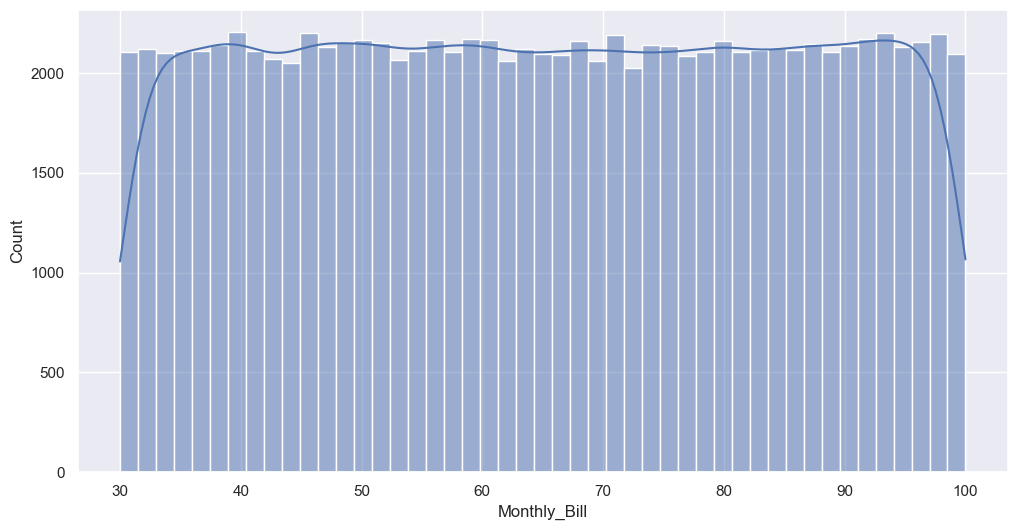

In [36]:
sns.histplot(data['Monthly_Bill'],kde=True)

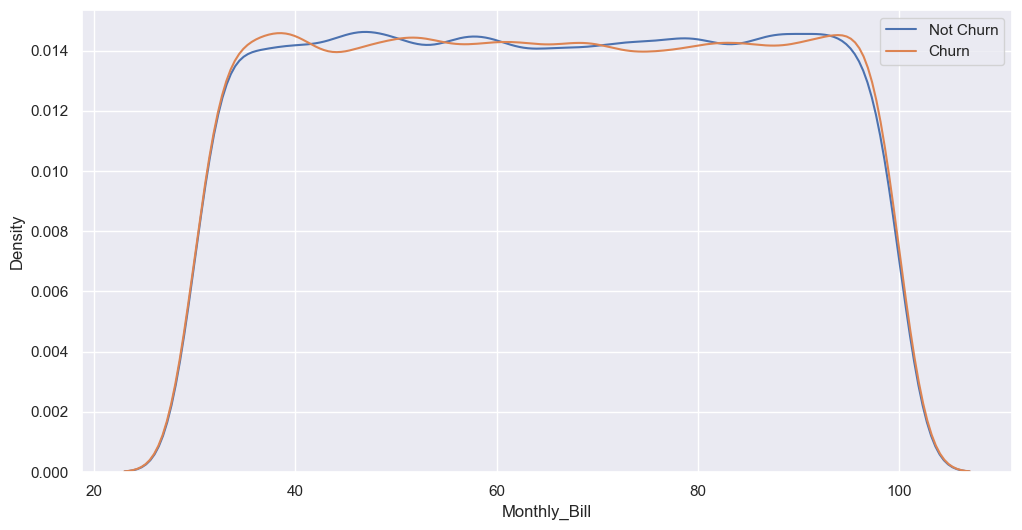

In [37]:
sns.kdeplot(data.loc[(data['Churn']==0),'Monthly_Bill'],label='Not Churn')
sns.kdeplot(data.loc[(data['Churn']==1),'Monthly_Bill'],label='Churn')
plt.legend()

In [38]:
data.columns

Index(['Age', 'Gender', 'Location', 'Subscription_Length_Months',
       'Monthly_Bill', 'Total_Usage_GB', 'Churn'],
      dtype='object')

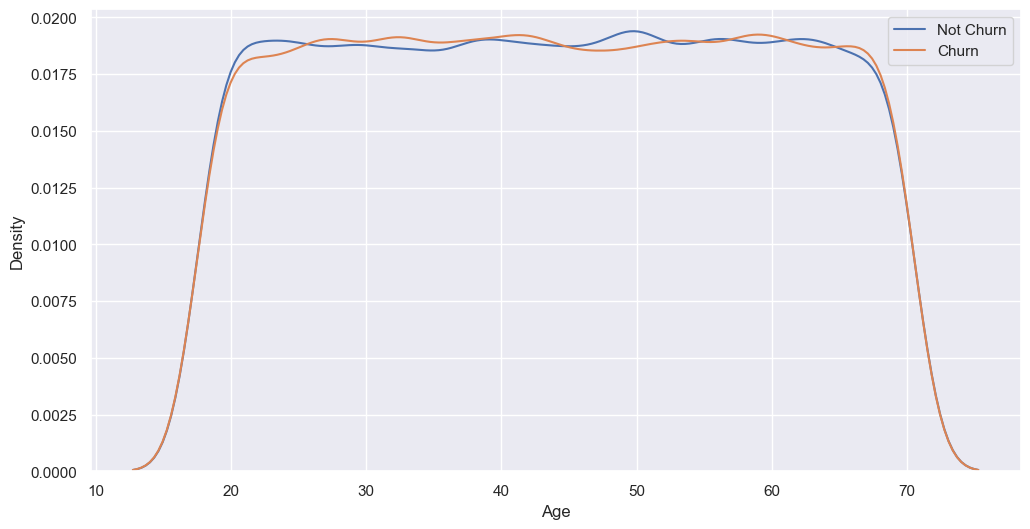

In [39]:
sns.kdeplot(data.loc[(data['Churn']==0),'Age'],label='Not Churn')
sns.kdeplot(data.loc[(data['Churn']==1),'Age'],label='Churn')
plt.legend()

In [40]:
data

,Age,Gender,Location,Subscription_Length_Months,Monthly_Bill,Total_Usage_GB,Churn
0,63,Male,Los Angeles,17,73.36,236,0
1,62,Female,New York,1,48.76,172,0
2,24,Female,Los Angeles,5,85.47,460,0
3,36,Female,Miami,3,97.94,297,1
4,46,Female,Miami,19,58.14,266,0
...,...,...,...,...,...,...,...
99995,33,Male,Houston,23,55.13,226,1
99996,62,Female,New York,19,61.65,351,0
99997,64,Male,Chicago,17,96.11,251,1
99998,51,Female,New York,20,49.25,434,1


#### Since from the above analysis it can be seen that both male and female customers churn rate are same and it is also same with location that is their is equal rate in all loaction
#### So we decided to drop the gender and location columns as they are equally distributed among their categories

In [41]:
data=data.drop(['Gender','Location'],axis=1)

In [42]:
data

,Age,Subscription_Length_Months,Monthly_Bill,Total_Usage_GB,Churn
0,63,17,73.36,236,0
1,62,1,48.76,172,0
2,24,5,85.47,460,0
3,36,3,97.94,297,1
4,46,19,58.14,266,0
...,...,...,...,...,...
99995,33,23,55.13,226,1
99996,62,19,61.65,351,0
99997,64,17,96.11,251,1
99998,51,20,49.25,434,1


In [43]:
data.dtypes

Age                             int64
Subscription_Length_Months      int64
Monthly_Bill                  float64
Total_Usage_GB                  int64
Churn                           int64
dtype: object

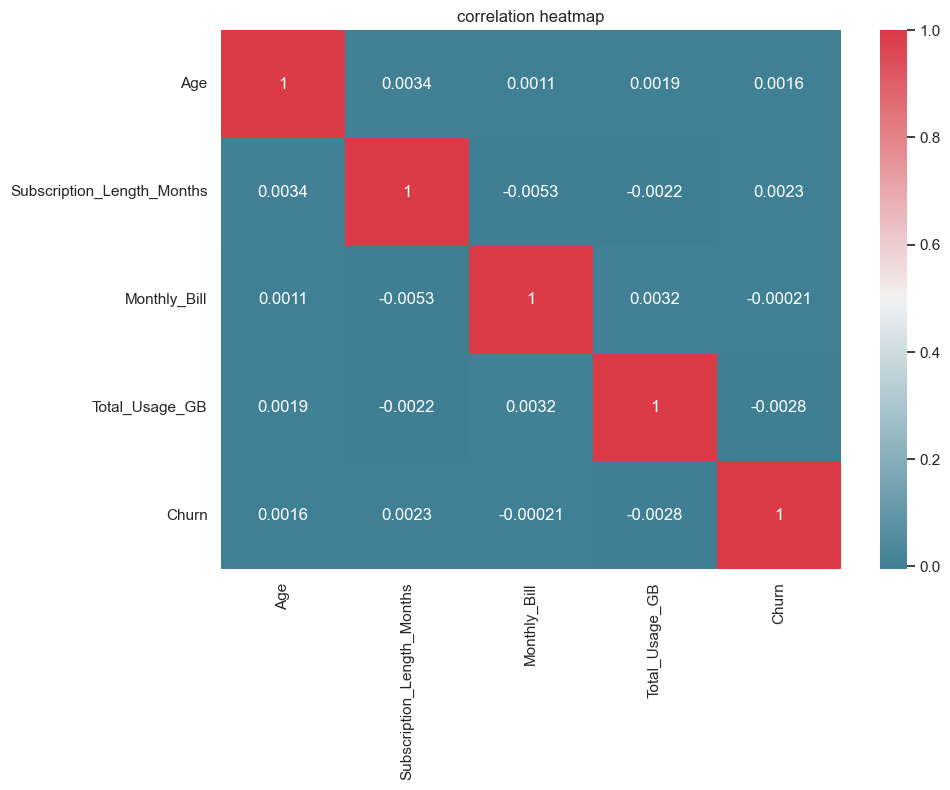

In [45]:
corr=data.corr()
plt.figure(figsize=(10,7))
cmap=sns.diverging_palette(220,10,as_cmap=True)
sns.heatmap(corr,annot=True,cmap=cmap)
plt.title("correlation heatmap")
plt.show()

## Model Building

In [46]:
X=data.drop(['Churn'],axis=1)
Y=data.Churn

In [47]:
X

,Age,Subscription_Length_Months,Monthly_Bill,Total_Usage_GB
0,63,17,73.36,236
1,62,1,48.76,172
2,24,5,85.47,460
3,36,3,97.94,297
4,46,19,58.14,266
...,...,...,...,...
99995,33,23,55.13,226
99996,62,19,61.65,351
99997,64,17,96.11,251
99998,51,20,49.25,434


### Train Test Split

In [48]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,Y,test_size=0.20,random_state=42)

In [49]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((80000, 4), (20000, 4), (80000,), (20000,))

In [50]:
def model_report(model,X_train,y_train,X_test,y_test):
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)

    train_acc = accuracy_score(train_pred, y_train)
    test_acc = accuracy_score(test_pred, y_test)
    prec = precision_score(y_test, test_pred)
    recc = recall_score(y_test, test_pred)
    f1 = f1_score(y_test, test_pred)
    acc_matrices = {'Train accuracy':train_acc,'Test accuracy':test_acc,'Precision':prec,'Recall':recc,'F1 Score':f1}

    print('\nTraining Accuracy Score: ',train_acc)
    print('Testing Accuracy Score: ',test_acc)
    print('Precision on test data: ',prec)
    print('Recall on test data: ',recc)
    print('F1 score on test data: ',f1)
    print('\n========================================================')
    print('Classification Report on Train data')
    print(classification_report(train_pred, y_train))
    print('\n========================================================')
    print('Classification Report on Test data')
    print(classification_report(test_pred, y_test))

    print('\n========================================================')
    # Plotting Confusion Matrix and ROC curve
    f,ax =  plt.subplots(1,2,figsize=(14,6))
    #plt.figure(figsize=(6,4))
    ConfMatrix = confusion_matrix(test_pred, y_test)
    sns.heatmap(ConfMatrix,annot=True, cmap='YlGnBu', fmt="d", 
                xticklabels = ['Non-default', 'Default'], 
                yticklabels = ['Non-default', 'Default'],linewidths=.5,ax = ax[0])
    ax[0].set_ylabel('True label')
    ax[0].set_xlabel('Predicted label')
    ax[0].set_title('Confusion Matrix')

    global fpr,tpr,thresholds
    fpr,tpr,thresholds = roc_curve(test_pred, y_test)
    ax[1].plot(fpr,tpr,color = 'r')
    ax[1].plot(fpr,fpr,color = 'green')
    ax[1].set_ylabel('TPR')
    ax[1].set_xlabel('FPR')
    ax[1].set_title('ROC Curve')
    plt.show()
    return acc_matrices

## Logistic Regression

In [51]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression()


Training Accuracy Score:  0.502575
Testing Accuracy Score:  0.49985
Precision on test data:  0.49306964164976336
Recall on test data:  0.2940227799616974
F1 score on test data:  0.36837784934015283

Classification Report on Train data
              precision    recall  f1-score   support

           0       0.71      0.50      0.59     56422
           1       0.30      0.50      0.37     23578

    accuracy                           0.50     80000
   macro avg       0.50      0.50      0.48     80000
weighted avg       0.59      0.50      0.52     80000


Classification Report on Test data
              precision    recall  f1-score   support

           0       0.70      0.50      0.59     14084
           1       0.29      0.49      0.37      5916

    accuracy                           0.50     20000
   macro avg       0.50      0.50      0.48     20000
weighted avg       0.58      0.50      0.52     20000




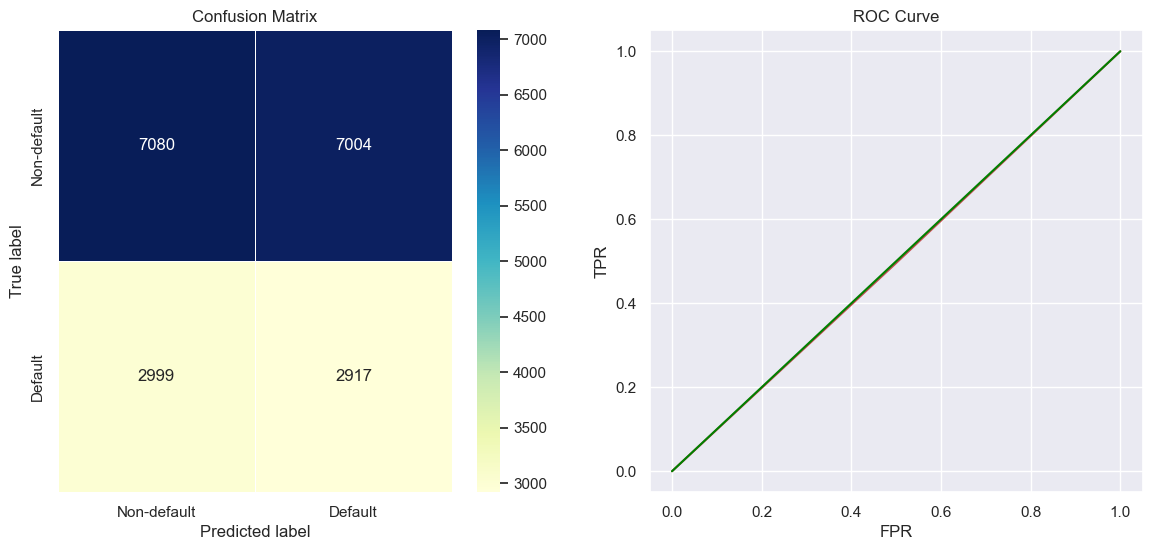

{'Train accuracy': 0.502575,
 'Test accuracy': 0.49985,
 'Precision': 0.49306964164976336,
 'Recall': 0.2940227799616974,
 'F1 Score': 0.36837784934015283}

In [52]:
model_report(logreg,X_train,y_train,X_test, y_test)

In [53]:
model={}

In [54]:
model['Logistic Regresion']={'Train accuracy': 0.502575,
 'Test accuracy': 0.49985,
 'Precision': 0.49306964164976336,
 'Recall': 0.2940227799616974,
 'F1 Score': 0.36837784934015283}

## Decision Tree

In [55]:
DT_classifier = DecisionTreeClassifier()
DT_classifier.fit(X_train,y_train)

DecisionTreeClassifier()


Training Accuracy Score:  1.0
Testing Accuracy Score:  0.50555
Precision on test data:  0.501592039800995
Recall on test data:  0.5081141014010684
F1 score on test data:  0.5048320064092934

Classification Report on Train data
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     40142
           1       1.00      1.00      1.00     39858

    accuracy                           1.00     80000
   macro avg       1.00      1.00      1.00     80000
weighted avg       1.00      1.00      1.00     80000


Classification Report on Test data
              precision    recall  f1-score   support

           0       0.50      0.51      0.51      9950
           1       0.51      0.50      0.50     10050

    accuracy                           0.51     20000
   macro avg       0.51      0.51      0.51     20000
weighted avg       0.51      0.51      0.51     20000




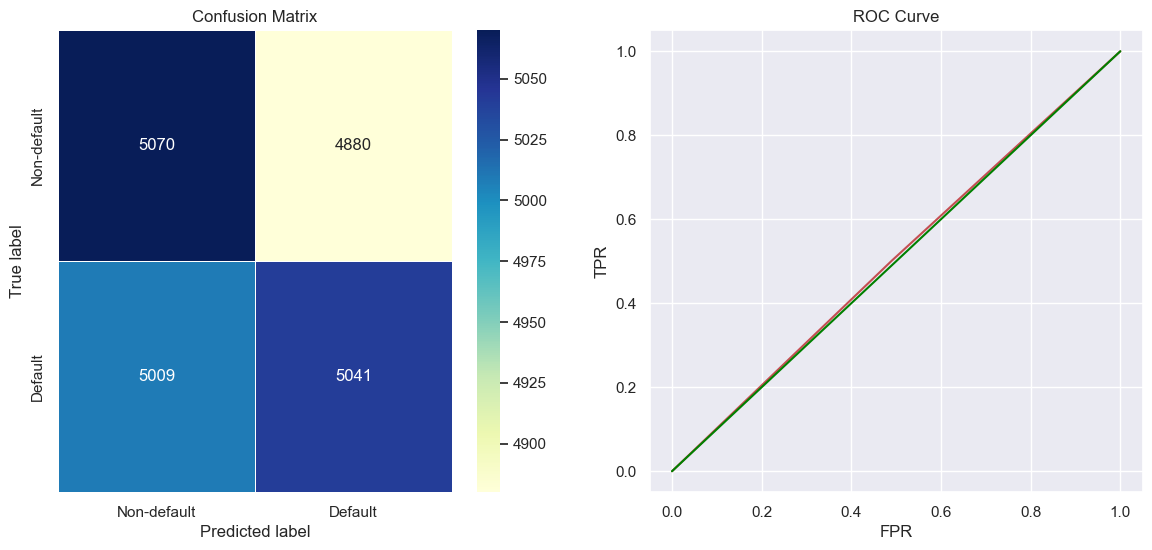

{'Train accuracy': 1.0,
 'Test accuracy': 0.50555,
 'Precision': 0.501592039800995,
 'Recall': 0.5081141014010684,
 'F1 Score': 0.5048320064092934}

In [56]:
model_report(DT_classifier,X_train,y_train,X_test, y_test)

In [57]:
model['Decision Tree']={'Train accuracy': 1.0,
 'Test accuracy': 0.50555,
 'Precision': 0.501592039800995,
 'Recall': 0.5081141014010684,
 'F1 Score': 0.5048320064092934}

## Random Forest

In [58]:
RF_classifier=RandomForestClassifier()
RF_classifier.fit(X_train,y_train)

RandomForestClassifier()


Training Accuracy Score:  1.0
Testing Accuracy Score:  0.5025
Precision on test data:  0.49847641063360304
Recall on test data:  0.47817760306420726
F1 score on test data:  0.4881160613231814

Classification Report on Train data
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     40142
           1       1.00      1.00      1.00     39858

    accuracy                           1.00     80000
   macro avg       1.00      1.00      1.00     80000
weighted avg       1.00      1.00      1.00     80000


Classification Report on Test data
              precision    recall  f1-score   support

           0       0.53      0.51      0.52     10483
           1       0.48      0.50      0.49      9517

    accuracy                           0.50     20000
   macro avg       0.50      0.50      0.50     20000
weighted avg       0.50      0.50      0.50     20000




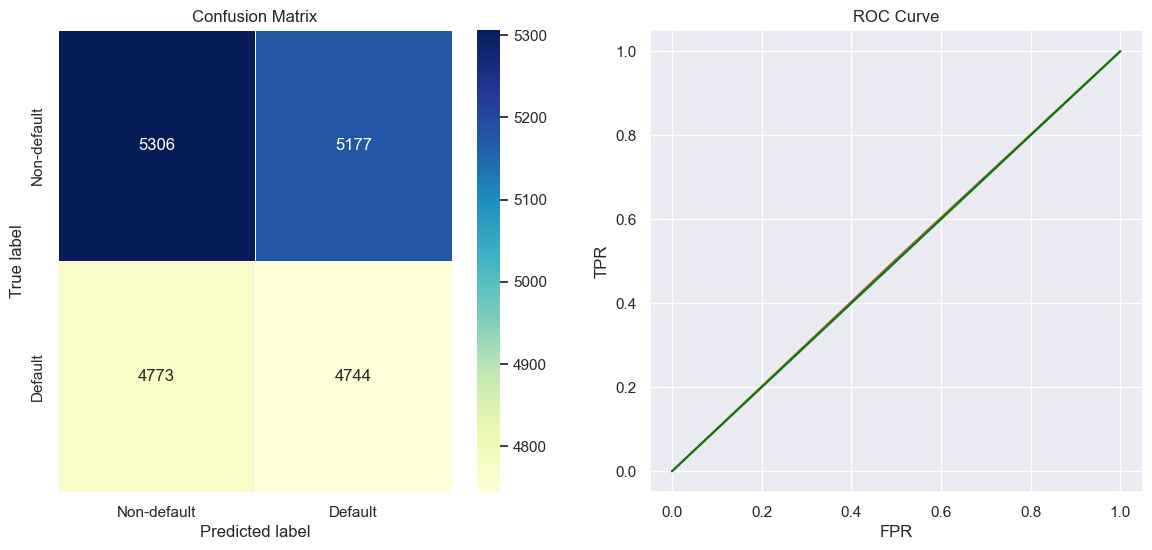

{'Train accuracy': 1.0,
 'Test accuracy': 0.5025,
 'Precision': 0.49847641063360304,
 'Recall': 0.47817760306420726,
 'F1 Score': 0.4881160613231814}

In [59]:
model_report(RF_classifier,X_train,y_train,X_test, y_test)

In [60]:
model['Random Forest']={'Train accuracy': 1.0,
 'Test accuracy': 0.5025,
 'Precision': 0.49847641063360304,
 'Recall': 0.47817760306420726,
 'F1 Score': 0.4881160613231814}

## XGBM

In [61]:
xg_classifier = XGBClassifier()
xg_classifier.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)


Training Accuracy Score:  0.64725
Testing Accuracy Score:  0.5032
Precision on test data:  0.4992286331379204
Recall on test data:  0.4892651950408225
F1 score on test data:  0.49419670128283444

Classification Report on Train data
              precision    recall  f1-score   support

           0       0.66      0.65      0.65     40898
           1       0.64      0.65      0.64     39102

    accuracy                           0.65     80000
   macro avg       0.65      0.65      0.65     80000
weighted avg       0.65      0.65      0.65     80000


Classification Report on Test data
              precision    recall  f1-score   support

           0       0.52      0.51      0.51     10277
           1       0.49      0.50      0.49      9723

    accuracy                           0.50     20000
   macro avg       0.50      0.50      0.50     20000
weighted avg       0.50      0.50      0.50     20000




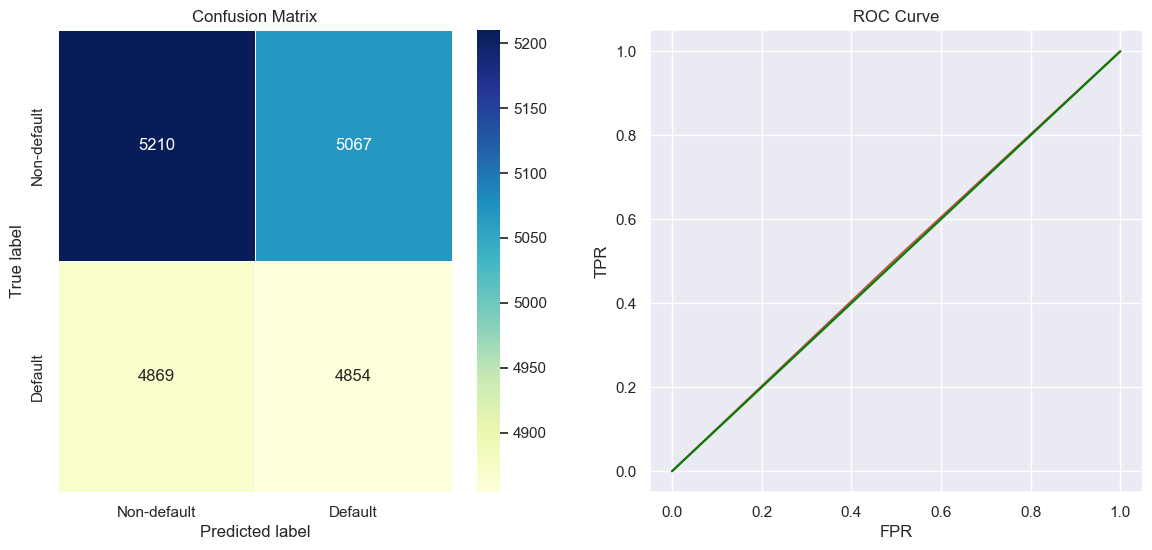

{'Train accuracy': 0.64725,
 'Test accuracy': 0.5032,
 'Precision': 0.4992286331379204,
 'Recall': 0.4892651950408225,
 'F1 Score': 0.49419670128283444}

In [62]:
model_report(xg_classifier,X_train,y_train,X_test, y_test)

In [63]:
model['XGBM']={'Train accuracy': 0.64725,
 'Test accuracy': 0.5032,
 'Precision': 0.4992286331379204,
 'Recall': 0.4892651950408225,
 'F1 Score': 0.49419670128283444}

In [64]:
pd.DataFrame(model) 

,Logistic Regresion,Decision Tree,Random Forest,XGBM
Train accuracy,0.502575,1.000000,1.000000,0.647250
Test accuracy,0.499850,0.505550,0.502500,0.503200
Precision,0.493070,0.501592,0.498476,0.499229
Recall,0.294023,0.508114,0.478178,0.489265
F1 Score,0.368378,0.504832,0.488116,0.494197


#### among all the models the decision is better so we further proceed with Decision Tree Classifier Algorithm

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.20, random_state = 42)
DT=DecisionTreeClassifier()
DT.fit(X_train,y_train)

DecisionTreeClassifier()

In [66]:
y_pred=DT.predict(X_test)
print('Score : ', DT.score(X, Y))
print('ROC',roc_auc_score(y_test,y_pred))

Score :  0.90119
ROC 0.5059922439759466


#### Checking with the some parameter like random state and max_depth for better accuracy

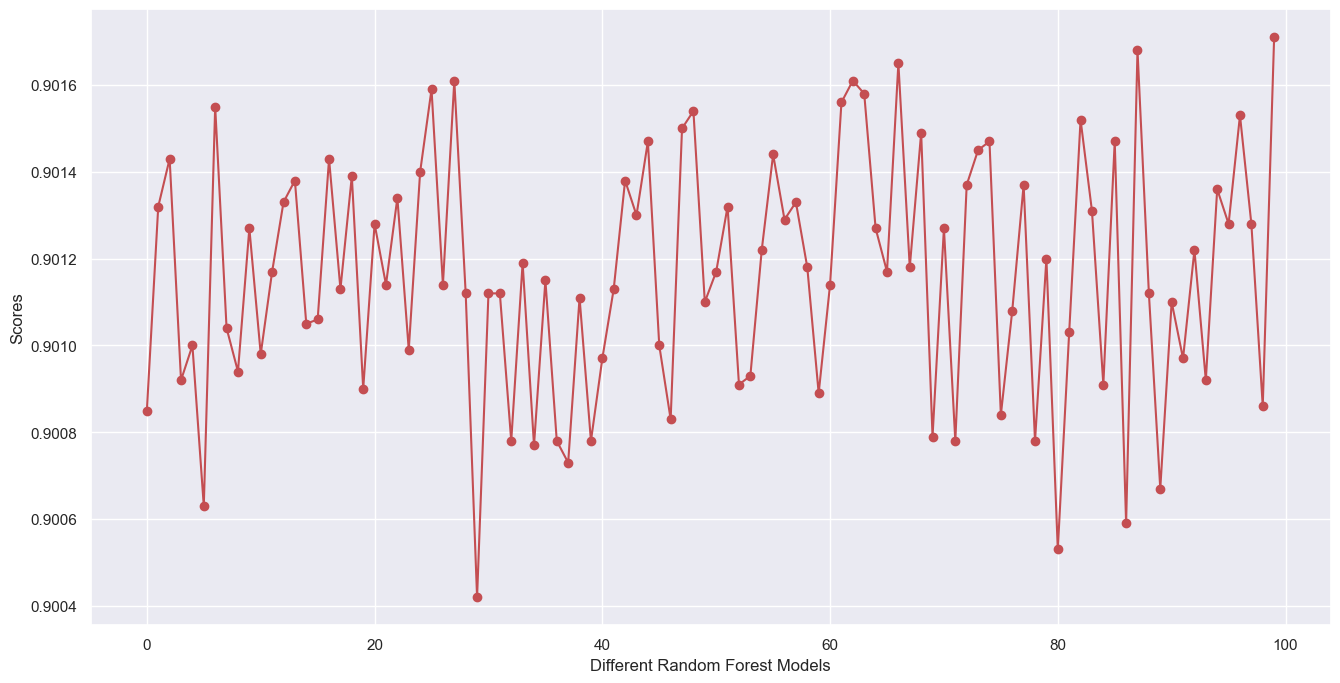

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.20, random_state = 42)

scores = []
for i in range(100):
    DT= DecisionTreeClassifier(random_state = i)
    DT.fit(X_train, y_train)
    scores.append(DT.score(X, Y))
    
plt.figure(figsize = (16, 8))
plt.plot(list(range(100)), scores, 'ro-')
plt.xlabel('Different Random Forest Models')
plt.ylabel('Scores')
plt.show()

#### here we found the random state at 98 at good score

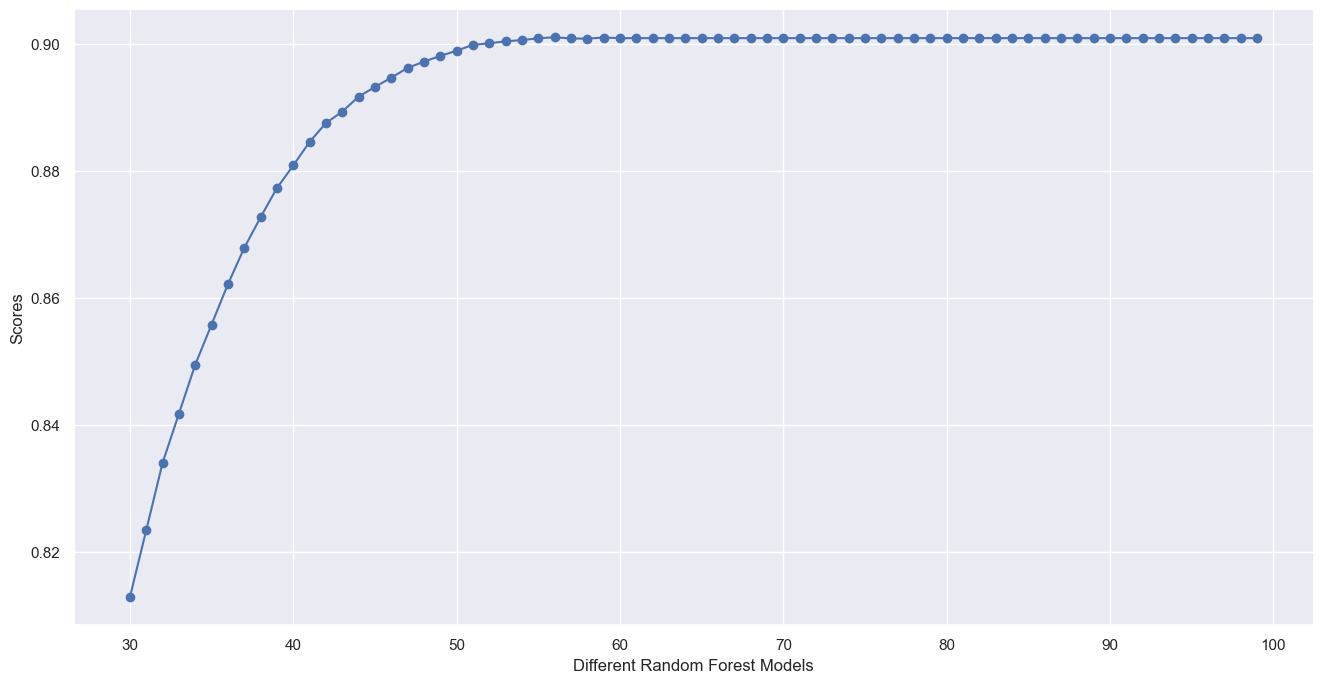

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.20, random_state = 42)

scores = []
for i in range(30,100):
    DT= DecisionTreeClassifier(max_depth=i,random_state = 98)
    DT.fit(X_train, y_train)
    scores.append(DT.score(X, Y))
    
plt.figure(figsize = (16, 8))
plt.plot(list(range(30,100)), scores, 'bo-')
plt.xlabel('Different Random Forest Models')
plt.ylabel('Scores')
#plt.grid()
plt.show()

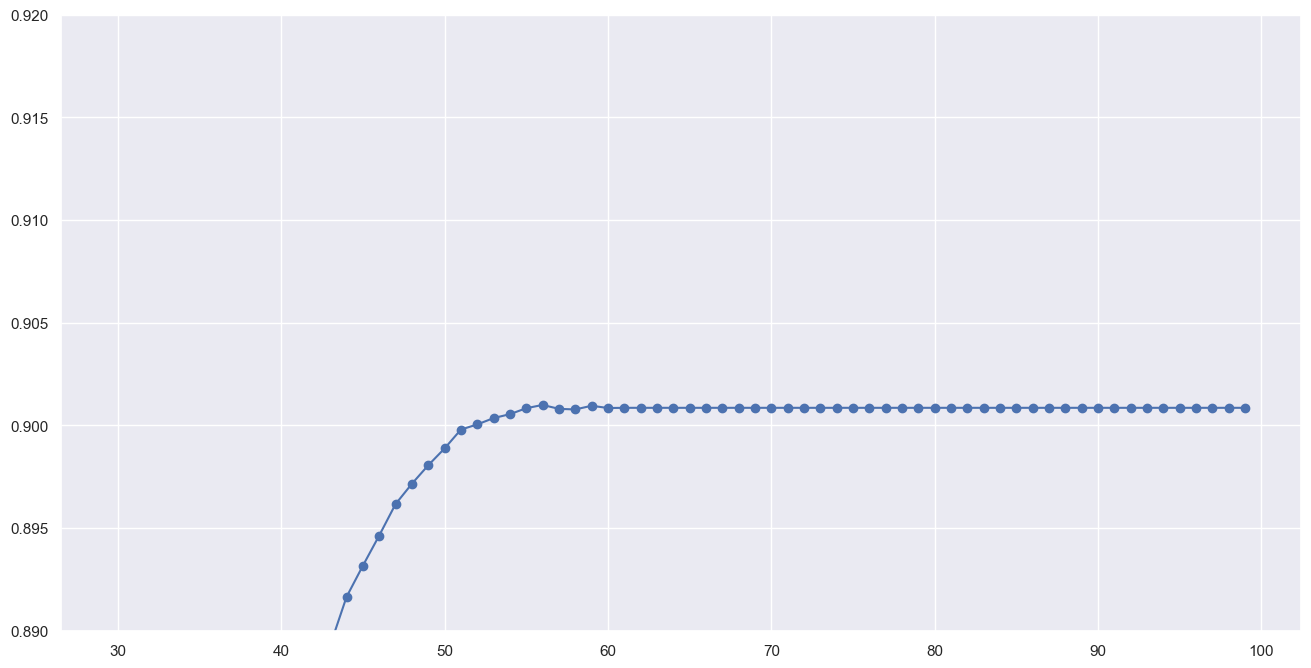

In [70]:
plt.figure(figsize = (16, 8))
plt.plot(list(range(30, 100)), scores, 'bo-')
plt.ylim(0.89, 0.92)
plt.show()

#### Here we found that at max_depth 56 the model as performance is good

#### So finally building the model with the random_state=98 and max_depth=56

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.20, random_state = 42)
DT=DecisionTreeClassifier(max_depth=56,random_state = 98)
DT.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=56, random_state=98)


Training Accuracy Score:  0.9996625
Testing Accuracy Score:  0.50635
Precision on test data:  0.5023785926660059
Recall on test data:  0.5109363975405705
F1 score on test data:  0.5066213582529608

Classification Report on Train data
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     40147
           1       1.00      1.00      1.00     39853

    accuracy                           1.00     80000
   macro avg       1.00      1.00      1.00     80000
weighted avg       1.00      1.00      1.00     80000


Classification Report on Test data
              precision    recall  f1-score   support

           0       0.50      0.51      0.51      9910
           1       0.51      0.50      0.51     10090

    accuracy                           0.51     20000
   macro avg       0.51      0.51      0.51     20000
weighted avg       0.51      0.51      0.51     20000




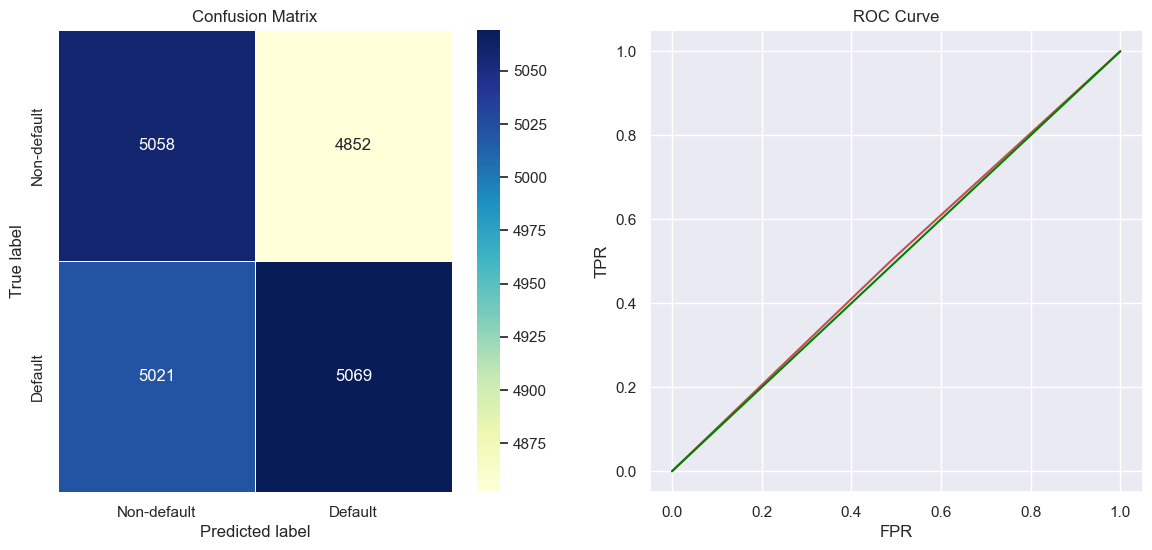

{'Train accuracy': 0.9996625,
 'Test accuracy': 0.50635,
 'Precision': 0.5023785926660059,
 'Recall': 0.5109363975405705,
 'F1 Score': 0.5066213582529608}

In [72]:
model_report(DT,X_train,y_train,X_test, y_test)

In [73]:
y_pred=DT.predict(X_test)
print('Score : ', DT.score(X, Y))
print('ROC',roc_auc_score(y_test,y_pred))

Score :  0.901
ROC 0.5063859485470489


##### As we found that the default parameter in the Decision Tree are same when we add the parameter to it the accuracy is same , since thier is less change in the parameters so we decided to proceed with the Decision Tree Model with the obtained paramters

In [74]:
data

,Age,Subscription_Length_Months,Monthly_Bill,Total_Usage_GB,Churn
0,63,17,73.36,236,0
1,62,1,48.76,172,0
2,24,5,85.47,460,0
3,36,3,97.94,297,1
4,46,19,58.14,266,0
...,...,...,...,...,...
99995,33,23,55.13,226,1
99996,62,19,61.65,351,0
99997,64,17,96.11,251,1
99998,51,20,49.25,434,1


In [75]:
X=data.drop('Churn',axis=1)
Y=data.Churn

In [80]:
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.20,random_state=42)
DT_classifier=DecisionTreeClassifier(max_depth=56,random_state=98)
DT_classifier.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=56, random_state=98)


Training Accuracy Score:  0.9996625
Testing Accuracy Score:  0.50635
Precision on test data:  0.5023785926660059
Recall on test data:  0.5109363975405705
F1 score on test data:  0.5066213582529608

Classification Report on Train data
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     40147
           1       1.00      1.00      1.00     39853

    accuracy                           1.00     80000
   macro avg       1.00      1.00      1.00     80000
weighted avg       1.00      1.00      1.00     80000


Classification Report on Test data
              precision    recall  f1-score   support

           0       0.50      0.51      0.51      9910
           1       0.51      0.50      0.51     10090

    accuracy                           0.51     20000
   macro avg       0.51      0.51      0.51     20000
weighted avg       0.51      0.51      0.51     20000




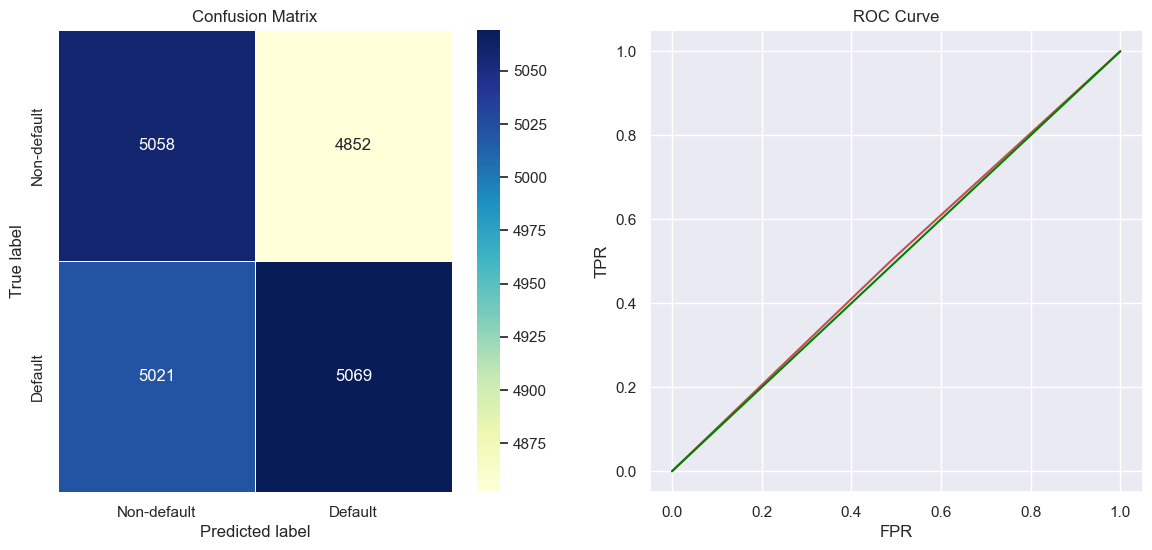

{'Train accuracy': 0.9996625,
 'Test accuracy': 0.50635,
 'Precision': 0.5023785926660059,
 'Recall': 0.5109363975405705,
 'F1 Score': 0.5066213582529608}

In [81]:
model_report(DT_classifier,X_train,y_train,X_test, y_test)

In [82]:
y_pred=DT_classifier.predict(X_test)
print('Score : ', DT.score(X, Y))
print('ROC',roc_auc_score(y_test,y_pred))

Score :  0.90152
ROC 0.5063859485470489


### Final Model

In [83]:
final_model=DecisionTreeClassifier(max_depth=56,random_state=98)
final_model.fit(X,Y)

DecisionTreeClassifier(max_depth=56, random_state=98)

#### Importing Pickle library for deplyoment

In [85]:
import pickle

In [86]:
filename='TRAINED.sav'
pickle.dump(final_model,open(filename,'wb'))

In [87]:
loaded_model=pickle.load(open('TRAINED.sav','rb'))

#### Verifying the model with known data

In [88]:
data

,Age,Subscription_Length_Months,Monthly_Bill,Total_Usage_GB,Churn
0,63,17,73.36,236,0
1,62,1,48.76,172,0
2,24,5,85.47,460,0
3,36,3,97.94,297,1
4,46,19,58.14,266,0
...,...,...,...,...,...
99995,33,23,55.13,226,1
99996,62,19,61.65,351,0
99997,64,17,96.11,251,1
99998,51,20,49.25,434,1


In [104]:
data.columns

Index(['Age', 'Subscription_Length_Months', 'Monthly_Bill', 'Total_Usage_GB',
       'Churn'],
      dtype='object')

In [99]:
input_data=[62,19,61.65,351]

In [102]:
input_data_as_numpy_array=np.array(input_data)
input_data_reshaped=input_data_as_numpy_array.reshape(1,-1)
prediction=loaded_model.predict(input_data_reshaped)
print(prediction)

[0]


In [103]:
if(prediction[0]==0):
    print('The person will be not be Churn')
else:
    print('The person will be Churn')

The person will be not be Churn


In [105]:
input_data=[27,19,76.57,173]

In [106]:
input_data_as_numpy_array=np.array(input_data)
input_data_reshaped=input_data_as_numpy_array.reshape(1,-1)
prediction=loaded_model.predict(input_data_reshaped)
print(prediction)

[1]


In [107]:
if(prediction[0]==0):
    print('The person will be not be Churn')
else:
    print('The person will be Churn')

The person will be Churn


#### Now the model ready for deployment